In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.ghostnet import GhostNet
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/ghostnet")
data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

25


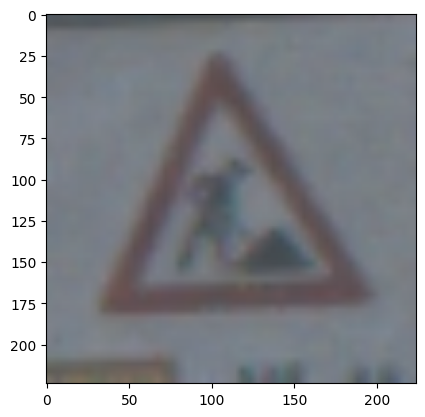

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = GhostNet(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
GhostNet                                                          --
├─Sequential: 1-1                                                 --
│    └─Conv2dNormActivation: 2-1                                  --
│    │    └─Conv2d: 3-1                                           432
│    │    └─BatchNorm2d: 3-2                                      32
│    │    └─ReLU: 3-3                                             --
│    └─GhostLayer: 2-2                                            --
│    │    └─ResBlock: 3-4                                         496
│    └─GhostLayer: 2-3                                            --
│    │    └─ResBlock: 3-5                                         2,460
│    └─GhostLayer: 2-4                                            --
│    │    └─ResBlock: 3-6                                         2,448
│    └─GhostLayer: 2-5                                            --
│    │    └─ResBlock:

# training

In [13]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 416/416 [01:11<00:00,  5.85it/s]


epoch 1 : 0.007825868444902321


100%|██████████| 416/416 [01:08<00:00,  6.11it/s]


epoch 2 : 0.0019454407860953675


100%|██████████| 416/416 [01:08<00:00,  6.05it/s]


epoch 3 : 0.0005530016475089584


100%|██████████| 416/416 [01:08<00:00,  6.04it/s]


epoch 4 : 0.0002672619834986388


100%|██████████| 416/416 [01:15<00:00,  5.48it/s]


epoch 5 : 0.00020435479351021968


100%|██████████| 416/416 [01:14<00:00,  5.57it/s]


epoch 6 : 0.0001468491107083572


100%|██████████| 416/416 [01:11<00:00,  5.85it/s]


epoch 7 : 8.817779162812328e-05


100%|██████████| 416/416 [01:08<00:00,  6.11it/s]


epoch 8 : 9.909478367503128e-05


100%|██████████| 416/416 [01:09<00:00,  5.99it/s]


epoch 9 : 0.00010030581217698945


100%|██████████| 416/416 [01:09<00:00,  5.97it/s]

epoch 10 : 8.315325533476862e-05


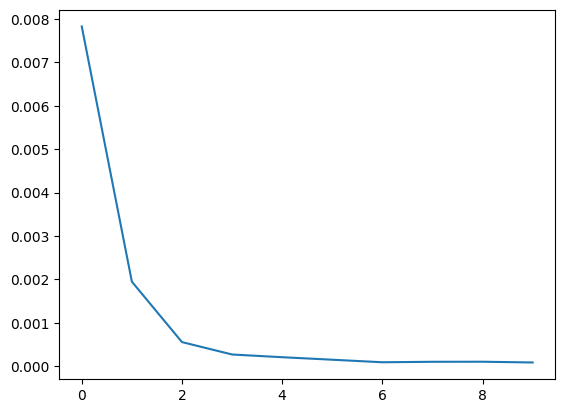

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(num_class, device)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [00:27<00:00,  7.20it/s]

[[ 46   7   0 ...   0   0   0]
 [  0 711   1 ...   0   0   0]
 [  0   8 736 ...   0   0   0]
 ...
 [  0   0   0 ...  84   0   0]
 [  0   0   0 ...   0  54   5]
 [  0   0   0 ...   0   1  70]]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.7666666666666667
1         : 0.9875
2         : 0.9813333333333333
3         : 0.9666666666666667
4         : 0.956060606060606
5         : 0.9301587301587302
6         : 0.88
7         : 0.9533333333333334
8         : 0.8911111111111111
9         : 0.9979166666666667
10        : 0.9954545454545455
11        : 0.9285714285714286
12        : 0.9376811594202898
13        : 0.9944444444444445
14        : 1.0
15        : 0.9904761904761905
16        : 0.88
17        : 0.9361111111111111
18        : 0.9
19        : 0.9666666666666667
20        : 0.5444444444444444
21        : 0.6333333333333333
22        : 0.8583333333333333
23        : 0.7933333333333333
24        : 0.7888888888888889
25        : 0.9166666666666666
26        : 0.9888888888888889
27        : 0.95
28        : 0.9066666666666666
29        : 1.0
30        : 0.7933333333333333
31        : 0.9407407407407408
32        : 1.0
33        : 0.5761904761904761
34        : 0.9666666666666667
35        : 0.9615384615384616

In [24]:
per_class_acc.mean()

0.8855156526337009

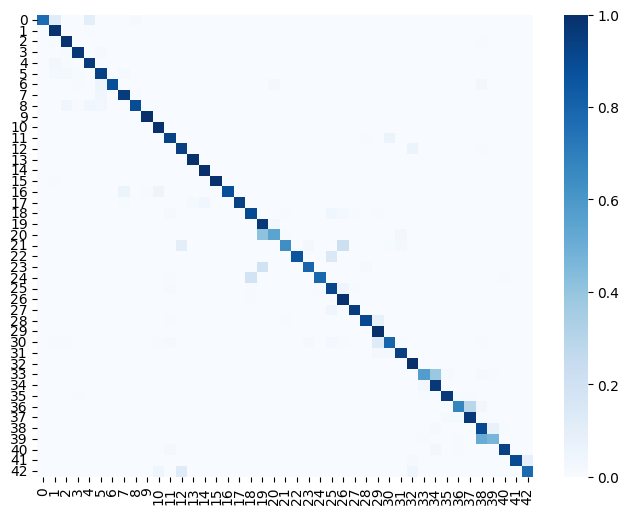

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'ghostnet.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'9.82MB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>